# Pattern Mining using Association rules - NYC collisions dataset

imports and raw data loading:

In [1]:
from sklearn.preprocessing import KBinsDiscretizer
from pandas import DataFrame, concat, read_csv
from matplotlib.pyplot import figure, show, subplots
from ds_charts import dummify, plot_line, multiple_line_chart
from  mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import OneHotEncoder

def dummify(df, vars_to_dummify):
  other_vars = [c for c in df.columns if not c in vars_to_dummify]
  encoder = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=bool)
  X = df[vars_to_dummify]
  encoder.fit(X)
  new_vars = encoder.get_feature_names(vars_to_dummify)
  trans_X = encoder.transform(X)
  dummy = DataFrame(trans_X, columns=new_vars, index=X.index)
  dummy = dummy.convert_dtypes(convert_boolean=True)

  final_df = concat([df[other_vars], dummy], axis=1)
  return final_df

data: DataFrame = read_csv('data/transformed/NYC_collisions_tabular_dumm.csv')


### Discretization:

In [2]:
from ds_charts import get_variable_types

variable_types = get_variable_types(data)
numeric_vars = variable_types['Numeric']
symbolic_vars = variable_types['Symbolic']
boolean_vars = variable_types['Binary']

df_nr = data[numeric_vars]
df_sb = data[symbolic_vars]
df_bool = data[boolean_vars]

In [3]:
N_BINS = 5
discretization = KBinsDiscretizer(n_bins=N_BINS, encode="ordinal", strategy="uniform")
discretization.fit(df_nr)
eq_width = DataFrame(discretization.transform(df_nr), index=data.index)

df = DataFrame(df_sb, index=data.index)
df = concat([df, df_bool, eq_width], axis=1)
df.columns = symbolic_vars + boolean_vars + numeric_vars
df.head()

,PERSON_INJURY,CONTRIBUTING_FACTOR_Unspecified,CONTRIBUTING_FACTOR_Pedestrian/Bicyclist/Other Pedestrian Error/Confusion,CONTRIBUTING_FACTOR_Driver Inattention/Distraction,CONTRIBUTING_FACTOR_Failure to Yield Right-of-Way,CONTRIBUTING_FACTOR_Traffic Control Disregarded,CONTRIBUTING_FACTOR_Alcohol Involvement,CONTRIBUTING_FACTOR_Other Vehicular,CONTRIBUTING_FACTOR_View Obstructed/Limited,CONTRIBUTING_FACTOR_Cell Phone (hand-Held),...,PED_ACTION_Other Actions in Roadway,PED_ACTION_Playing in Roadway,PED_ACTION_Pushing/Working on Car,PED_ACTION_Riding/Walking Along Highway Against Traffic,PED_ACTION_Riding/Walking Along Highway With Traffic,PED_ACTION_Unknown,PED_ACTION_Working in Roadway,CRASH_DATE,CRASH_TIME,PERSON_AGE
0,Injured,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,0.0,0.0,1.0
1,Injured,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,0.0,0.0,1.0
2,Injured,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0.0,0.0,2.0
3,Injured,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,0.0,0.0,3.0
4,Injured,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,0.0,0.0,1.0


### dummify

In [4]:
vars = ['PERSON_INJURY', 'PERSON_AGE', 'CRASH_DATE', 'CRASH_TIME']
discretized_data = dummify(df, vars_to_dummify=vars)


## Patterns

Processing 10100 combinations | Sampling itemset size 2
2520 patterns


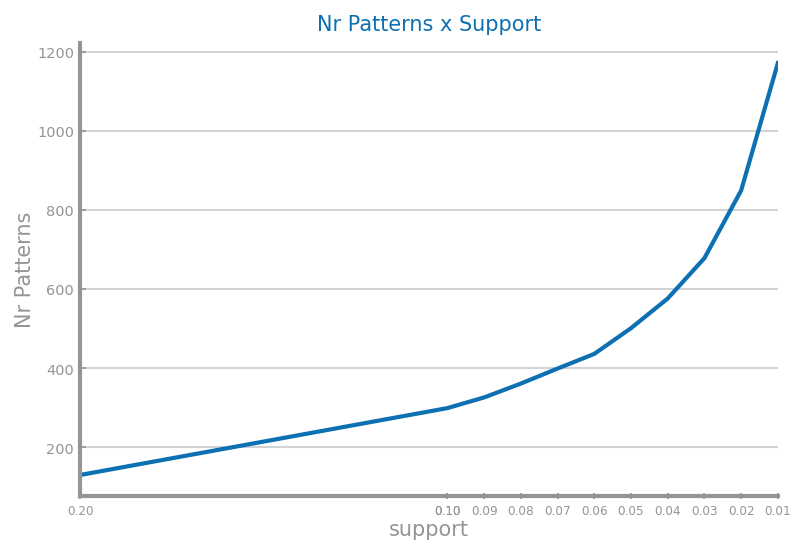

In [5]:
MIN_SUP: float = 0.001
var_min_sup =[0.2, 0.1] + [i*MIN_SUP for i  in range(100, 0, -10)]
aux = DataFrame(discretized_data)
patterns: DataFrame = apriori(aux, min_support=MIN_SUP, max_len=2, use_colnames=True, verbose=True)
print(len(patterns),'patterns')
nr_patterns = []
for sup in var_min_sup:
    pat = patterns[patterns['support']>=sup]
    nr_patterns.append(len(pat))

figure(figsize=(6, 4))
plot_line(var_min_sup, nr_patterns, title='Nr Patterns x Support', xlabel='support', ylabel='Nr Patterns')
show()

## Association Rules

In [6]:
MIN_CONF: float = 0.1
rules = association_rules(patterns, metric='confidence', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

	found 1010 rules


In [7]:
def plot_top_rules(rules: DataFrame, metric: str, per_metric: str) -> None:
    _, ax = subplots(figsize=(6, 3))
    ax.grid(False)
    ax.set_axis_off()
    ax.set_title(f'TOP 10 per Min {per_metric} - {metric}', fontweight="bold")
    text = ''
    cols = ['antecedents', 'consequents']
    rules[cols] = rules[cols].applymap(lambda x: tuple(x))
    for i in range(len(rules)):
        rule = rules.iloc[i]
        text += f"{rule['antecedents']} ==> {rule['consequents']}"
        text += f"(s: {rule['support']:.2f}, c: {rule['confidence']:.2f}, lift: {rule['lift']:.2f})\n"
    ax.text(0, 0, text)
    show()

def analyse_per_metric(rules: DataFrame, metric: str, metric_values: list) -> list:
    print(f'Analyse per {metric}...')
    conf = {'avg': [], 'top25%': [], 'top10': []}
    lift = {'avg': [], 'top25%': [], 'top10': []}
    top_conf = []
    top_lift = []
    nr_rules = []
    for m in metric_values:
        rs = rules[rules[metric] >= m]
        nr_rules.append(len(rs))
        conf['avg'].append(rs['confidence'].mean(axis=0))
        lift['avg'].append(rs['lift'].mean(axis=0))

        top_conf = rs.nlargest(int(0.25*len(rs)), 'confidence')
        conf['top25%'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(int(0.25*len(rs)), 'lift')
        lift['top25%'].append(top_lift['lift'].mean(axis=0))

        top_conf = rs.nlargest(10, 'confidence')
        conf['top10'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(10, 'lift')
        lift['top10'].append(top_lift['lift'].mean(axis=0))

    _, axs = subplots(1, 2, figsize=(10, 5), squeeze=False)
    multiple_line_chart(metric_values, conf, ax=axs[0, 0], title=f'Avg Confidence x {metric}',
                           xlabel=metric, ylabel='Avg confidence')
    multiple_line_chart(metric_values, lift, ax=axs[0, 1], title=f'Avg Lift x {metric}',
                           xlabel=metric, ylabel='Avg lift')
    show()

    plot_top_rules(top_conf, 'confidence', metric)
    plot_top_rules(top_lift, 'lift', metric)

    return nr_rules

### Quality evaluation per support

Analyse per support...


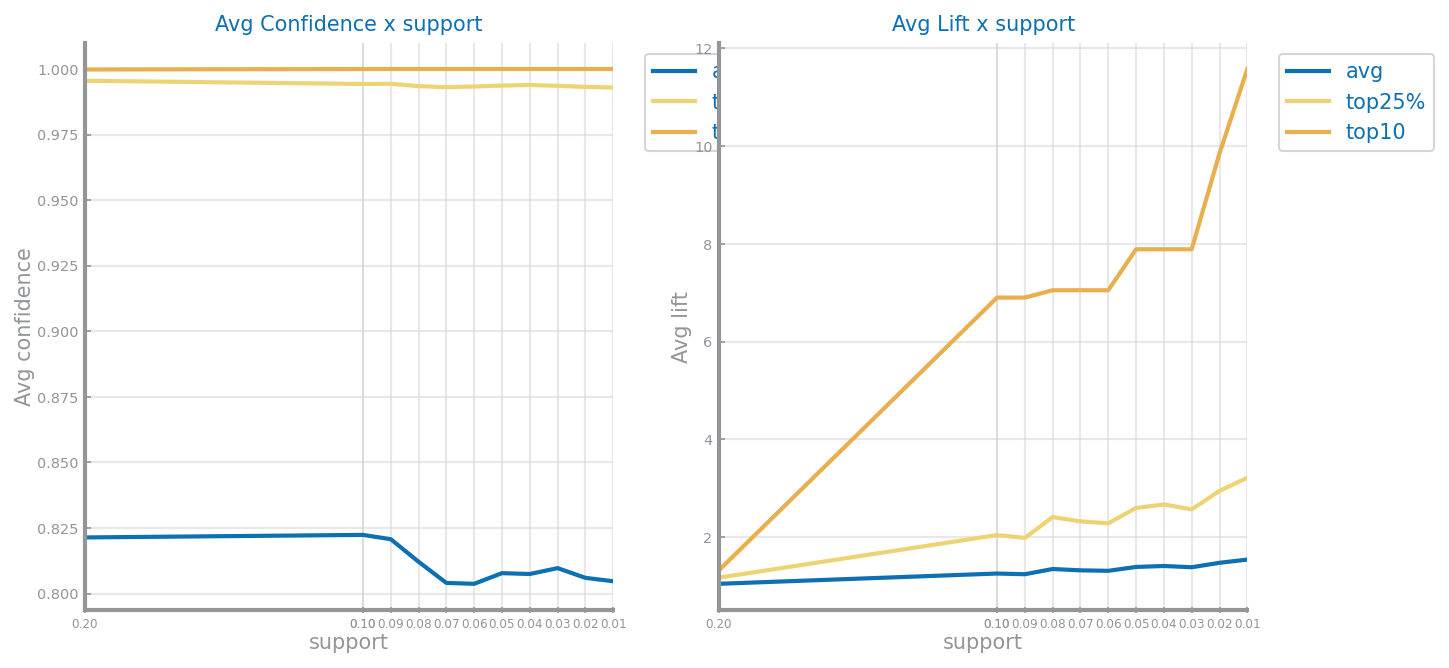

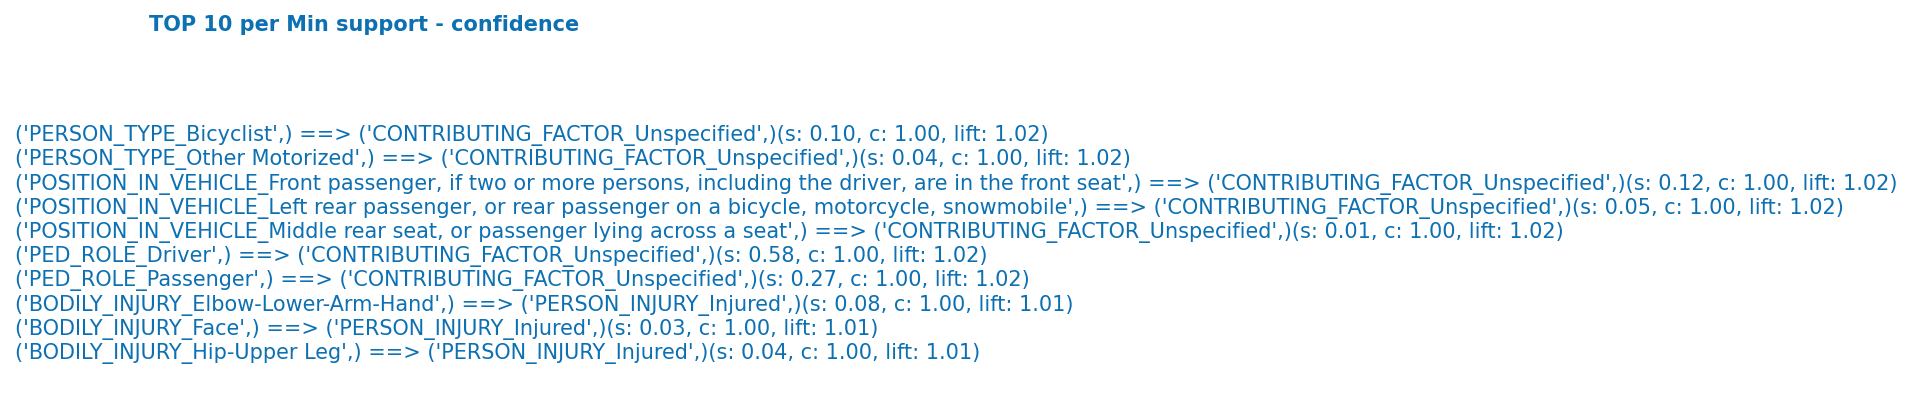

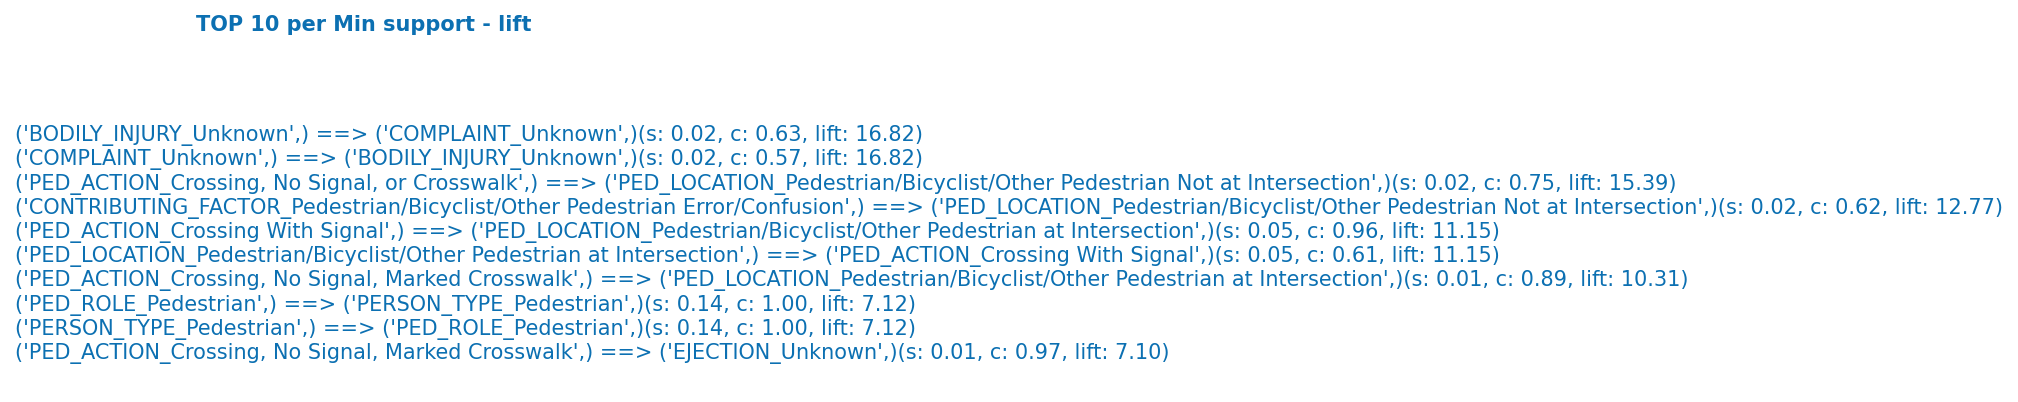

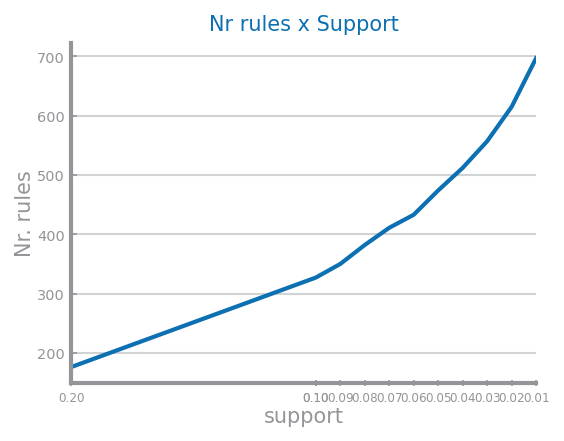

In [8]:
nr_rules_sp = analyse_per_metric(rules, 'support', var_min_sup)
plot_line(var_min_sup, nr_rules_sp, title='Nr rules x Support', xlabel='support', ylabel='Nr. rules', percentage=False)

### Quality evaluation per confidence

Analyse per confidence...


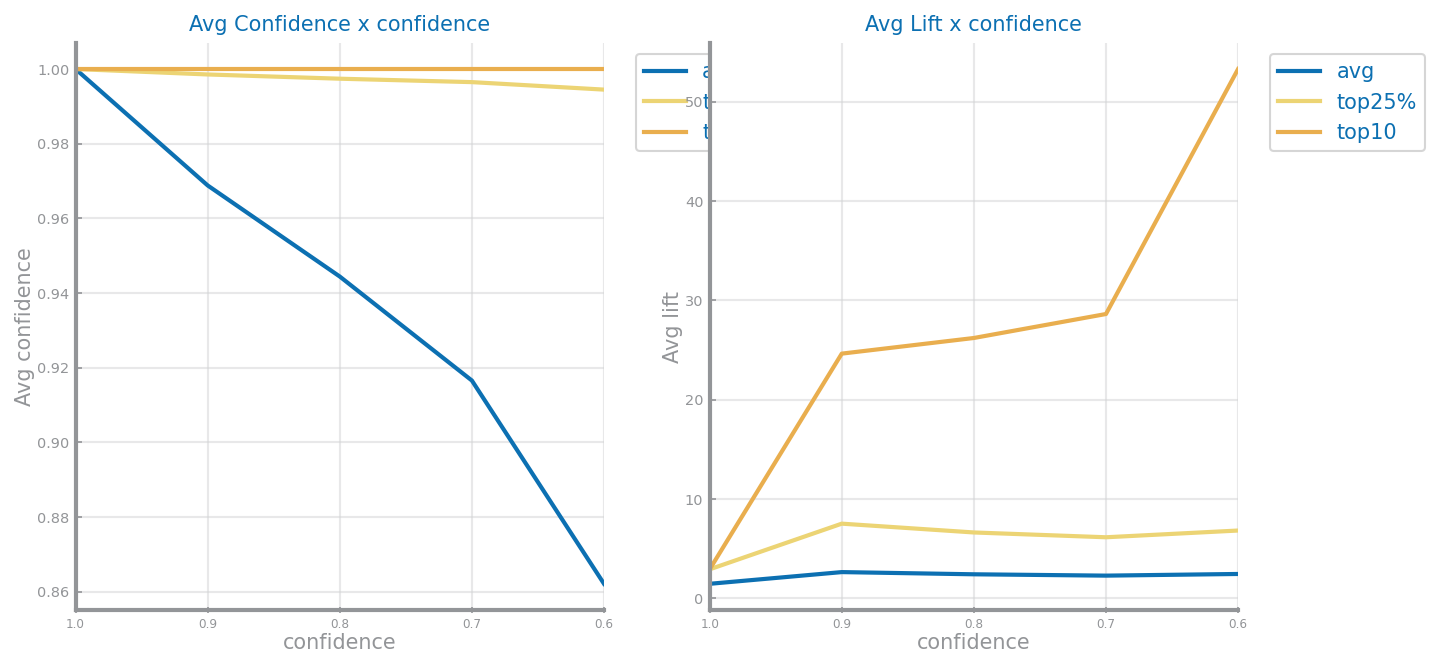

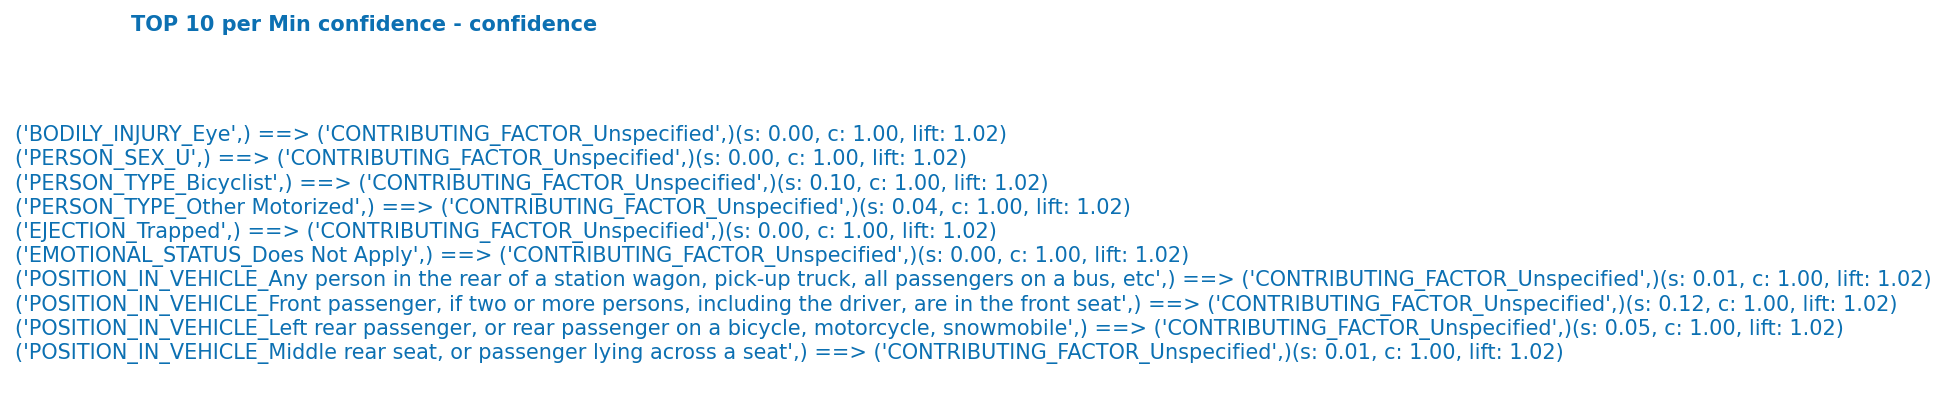

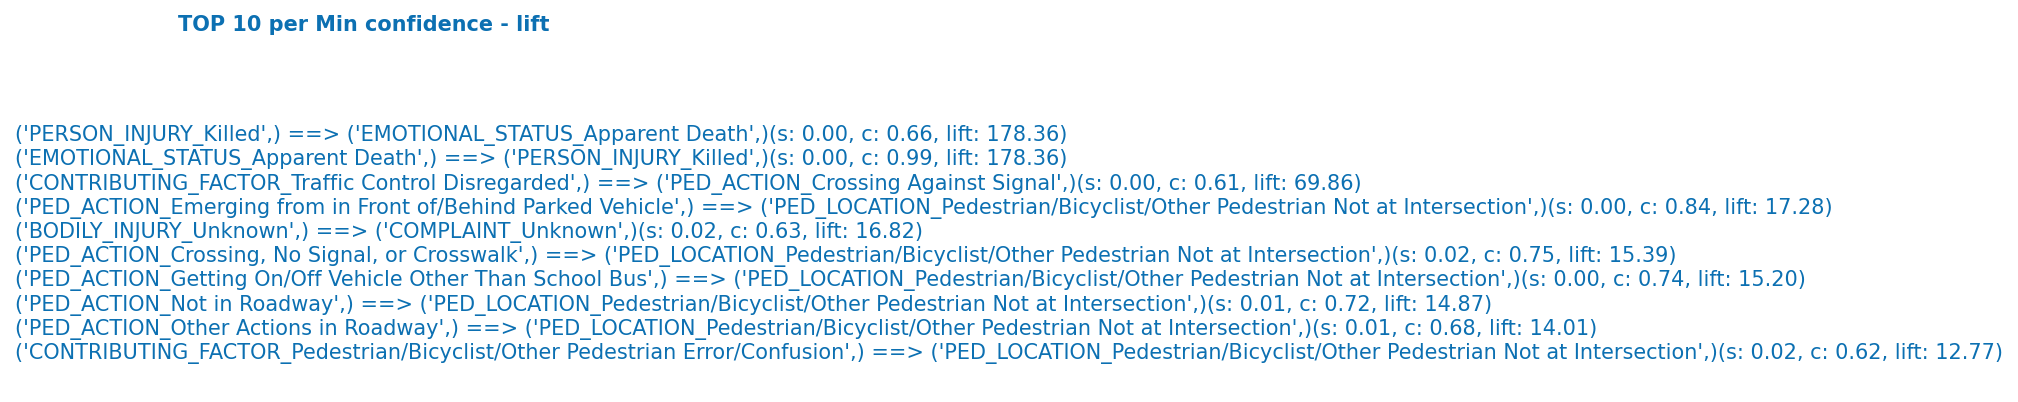

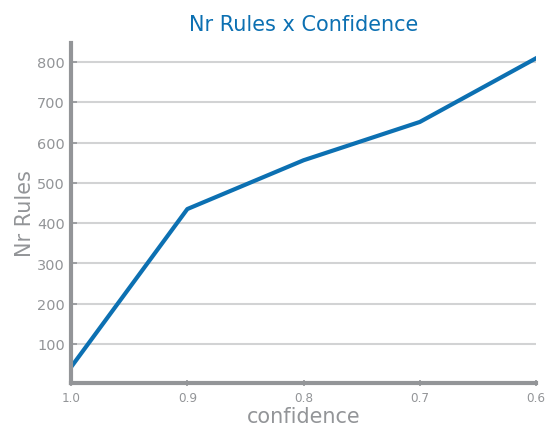

In [9]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
nr_rules_cf = analyse_per_metric(rules, 'confidence', var_min_conf)
plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x Confidence', xlabel='confidence', ylabel='Nr Rules', percentage=False)